In [426]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
#from sklearn.ensemble import RandomForestRegressor



In [427]:
#import math
import torch
import gpytorch

In [428]:
from scipy import stats

In [429]:
ls_model = ['simpleGP','multi-task-same-input']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['ohe','LVGP','LMGP']
ls_remove_train_outlier = [0,1]

In [430]:
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result

class MyGPR2(GaussianProcessRegressor):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        #self._max_iter = max_iter
        #self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':15000})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

In [432]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=6
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=6, rank=0
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [433]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
#df = pd.read_csv('data/dps-alldata.csv')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
df.head()

1843


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [434]:
# Update the sample identifier 
"""
    The protein concentration may deviate one from another in an acceptable range
    Thus, we remove the Protein concentration from sample identifier
"""
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

In [435]:
bins = [-np.inf, 50, 100,np.inf]
names = ['low', 'medium', 'high']

df['NaClRange'] = pd.cut(df['NaCl_mM_'], bins, labels=names)

print(df['NaClRange'].unique())


bins = [-np.inf, 0,1]
names = ['zero', 'positive']

df['PS80_Range'] = pd.cut(df['PS80_'], bins, labels=names)

print(df['PS80_Range'].unique())

bins = [-np.inf, 0,np.inf]
names = ['zero', 'positive']

df['Sucrose_Range'] = pd.cut(df['Sucrose_'], bins, labels=names)

print(df['Sucrose_Range'].unique())

bins = [-np.inf, 0,np.inf]
names = ['zero', 'positive']

df['Trehalose_Range'] = pd.cut(df['Trehalose_'], bins, labels=names)

print(df['Trehalose_Range'].unique())

['low', 'high', 'medium']
Categories (3, object): ['low' < 'medium' < 'high']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']
['zero', 'positive']
Categories (2, object): ['zero' < 'positive']


[1, 22, 2, 1, 1, 42, 1, 11, 9, 32, 4, 28, 1, 1, 11, 1, 1, 1, 17, 1, 1, 18, 18, 4, 4, 4, 1, 12, 1, 1, 1, 26, 1, 1, 19, 18, 8, 3, 14, 68, 27, 1, 1, 67, 1, 28, 43, 16, 4, 4, 4, 12, 12, 12, 11, 11, 1, 17, 1, 1, 1, 18, 8, 4, 4, 4, 1, 1, 1, 18, 1, 1, 8, 1, 19, 8, 33, 8, 33, 7, 15, 11, 8, 1, 1, 1, 1, 1, 57, 2, 98, 32, 109, 29, 44, 28, 25, 12, 1, 16, 15, 2, 5, 7, 2, 12, 12, 12, 4, 10, 11, 11, 5, 6, 1, 1, 1, 1, 1, 20, 2, 21, 1, 21, 20, 4, 4, 4, 4, 1, 1, 1, 1, 1, 20, 2, 21, 1, 20, 18, 9, 1, 8, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 8, 1, 8, 25, 18, 25, 7, 2, 1, 12, 12, 12, 8, 6, 4]
92
The list of indices greater than or equal to n_data_th : [5, 9, 39, 43, 46, 76, 78, 88, 90, 91, 92, 94]


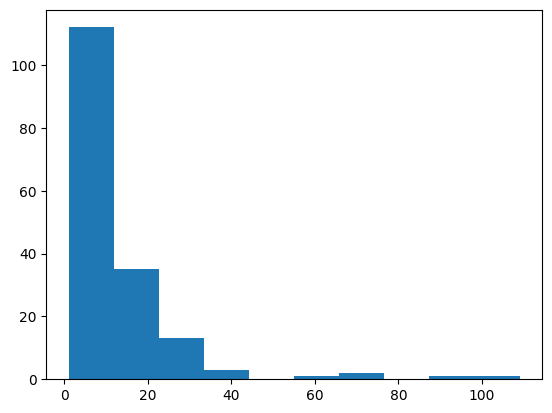

In [436]:
splits_formulation = list(df[cols_group + cols_feature01+cols_target].groupby(cols_feature01,dropna=True))
ndata_formulation = [len(df[1]) for df in splits_formulation]
print(ndata_formulation)
m = max(ndata_formulation)
print(ndata_formulation.index(m))
plt.hist(ndata_formulation)

n_data_th_formulation = 30
res_formulation = [idx for idx, val in enumerate(ndata_formulation) if val >= n_data_th_formulation]
print("The list of indices greater than or equal to n_data_th : " + str(res_formulation))

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


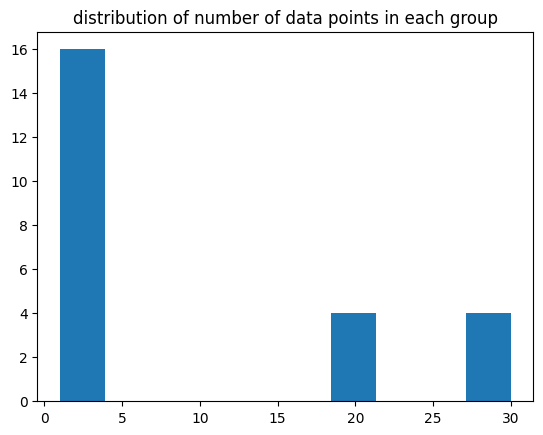

In [437]:
# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [579]:
tmp = [df[0] for df in splits_identifier]
print(tmp[1])
print(tmp[3])
print(tmp[5])

('FAP-TriNKET', 'DAB013887', 'BsAb', 'Thermal Stress', 50.0, 10.0)
('FAP-TriNKET', 'DAB014071', 'BsAb', 'Thermal Stress', 50.0, 10.0)
('FAP-TriNKET', 'DAB014072', 'BsAb', 'Thermal Stress', 50.0, 10.0)


In [581]:
tmp = [df[0] for df in splits_identifier]
print(tmp[8])
print(tmp[9])
print(tmp[10])
print(tmp[11])

('IL-2Ra', 'DNB547', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0)
('IL-2Ra', 'DNB553', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0)
('IL-2Ra', 'DNB557', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0)
('IL-2Ra', 'DNB558', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0)


In [438]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)

print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

True
True


In [439]:
split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]

In [484]:
keep1_inds = np.abs(stats.zscore(split1_target_df['UP_SEC_HMW_1']))<3
keep3_inds = np.abs(stats.zscore(split3_target_df['UP_SEC_HMW_3']))<3
keep5_inds = np.abs(stats.zscore(split5_target_df['UP_SEC_HMW_5']))<3

split1_target_df = split1_target_df[(keep1_inds)]
split3_target_df = split3_target_df[(keep3_inds)]
split5_target_df = split5_target_df[(keep5_inds)]

split1_formulation_df = split1_formulation_df[(keep1_inds)]
split3_formulation_df = split3_formulation_df[(keep3_inds)]
split5_formulation_df = split5_formulation_df[(keep5_inds)]

In [440]:
cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_HMW_1',
                   'UP_SEC_Monomer_3',	'UP_SEC_HMW_3',	
                   'UP_SEC_Monomer_5',	'UP_SEC_HMW_5']
#cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_Monomer_3']

In [485]:
n21_total_df = pd.concat((split1_formulation_df,split1_target_df,split3_target_df,split5_target_df),axis = 1)
#n21_total_df
ohe_n21_total_df = pd.get_dummies(n21_total_df, columns = ['Buffer'])
#ohe_n21_total_df.head()

In [442]:
cols_feature_new = ['Buffer_Acetate','Buffer_Citrate','Buffer_Histidine','NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']


## LVGP

In [512]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import cholesky
from scipy.optimize import minimize
from scipy.stats import norm
import time

from skopt.sampler import Lhs
from skopt.space import Space
import pandas as pd
import warnings
from sklearn.metrics import r2_score, mean_squared_error

from multiprocessing import Pool

In [513]:
def lvgp_kernel(X1, X2, phi_full):

    k = X1.shape[0]
    p = X1.shape[1]
    kk = X2.shape[0]

    R = np.zeros((k, kk))
    phi_full = np.array(phi_full)

    if p != len(phi_full):
        print('Shapes do not match.')
        exit(0)

    if k >= kk:
        for i in range(kk):
            R[:, i] = (np.power(X1.T - X2[i].reshape(-1, 1), 2) * (10 ** phi_full).reshape(-1, 1)).sum(axis=0)
    else:
        for i in range(k):
            R[i, :] = (np.power(X2.T - X1[i].reshape(-1, 1), 2) * (10 ** phi_full).reshape(-1, 1)).sum(axis=0)

    R = np.exp(-0.5 * R)

    return R

In [514]:
def lvgp_to_latent(X_qual, lvs_qual, n_lvs_qual, p_qual, z_vec, dim_z, k):
    """
    Transforms qualitative/categorical variables into latent variables.

    param X_qual Matrix or data frame containing (only) the qualitative/categorical data.
    param lvs_qual List containing levels of each qualitative variable
    param n_lvs_qual Number of levels of each qualitative variable
    param p_qual Number of qualitative variables
    param z_vec Latent variable parameters, i.e., latent variable values for each level of qualitative/categorical variables
    param dim_z Dimensionality of latent variables, usually 1 or 2
    param k Number of data points, equal to \code{nrow(X_qual)}

    return Matrix containing transformed data
    """

    X_qual_la = np.zeros((k, p_qual * dim_z))
    # note: the first levels of each variable are zeros in the latent space,
    # no need to touch upon.

    start = 0
    for i in range(p_qual):
        n_lvs = n_lvs_qual[i]
        lvs = lvs_qual[i]
        end = (dim_z) * (n_lvs - 1) + start

        z_i = z_vec[start: end]
        start = end

        # map
        zstart = 0
        for j in range(1, n_lvs):
            zend = dim_z + zstart
            X_qual_la[X_qual[:, i] == lvs[j], i*dim_z:(i+1)*dim_z] = z_i[zstart:zend]
            zstart = zend

    return X_qual_la

In [515]:
def lvgp_nll(p_quant, p_qual, lvs_qual, n_lvs_qual, dim_z, X_quant, X_qual, Y, min_eig, k, M):
    """
    description Calculates the negative log-likelihood (excluding all the constant terms) as described in \code{reference 1}.

    param hyperparam Hyperparameters of the LVGP model
    param p_quant Number of quantative variables
    param p_qual Number of qualitative variables
    param lvs_qual Levels of each qualitative variable
    param n_lvs_qual Number of levels of each qualitative variable
    param dim_z Dimensionality of latent variables, usually 1 or 2
    param X_quant Input data of quantative variables
    param X_qual Input data of qualitative variables
    param Y Vector containing the outputs of data points
    param min_eig The smallest eigen value that the correlation matrix is allowed to have, which determines the nugget added to the correlation matrix.
    param k Number of data points, \code{nrow(X_quant)} or \code{nrow(X_qual)}
    param M Vector of ones with length \code{k}

    """
    Y = Y.reshape(-1, 1)
    M = M.reshape(-1, 1)

    def nll(hyperparams):
        if p_qual == 0:
            # No qualitative variables
            R = lvgp_kernel(X_quant, X_quant, hyperparams)
        else:
            z_vec = hyperparams[p_quant:]
            X_qual_la = lvgp_to_latent(X_qual, lvs_qual, n_lvs_qual,
                                       p_qual, z_vec, dim_z, k)

            if X_quant is not None:
                X_full = np.hstack([X_quant, X_qual_la])
            else:
                X_full = X_qual_la

            phi_full = hyperparams[:p_quant].tolist()
            phi_full.extend([0 for i in range(p_qual * dim_z)])

            R = lvgp_kernel(X_full, X_full, phi_full)

        R = (R + R.T) / 2  # why?

        raw_min_eig = np.linalg.eigvalsh(R, 'U').min()

        #         raw_min_eig = raw_min_eig.min()
        if raw_min_eig < min_eig:
            R += (np.diag(np.full(k, 1)) * (min_eig - raw_min_eig))

        L = cholesky(R).T
        LinvM = np.linalg.solve(L, M)
        beta_hat = np.dot(LinvM.T, np.linalg.solve(L, Y) / np.sum(LinvM ** 2))
        beta_hat = float(beta_hat)

        temp = np.linalg.solve(L, Y - M*beta_hat)
        sigma2 = np.sum(temp ** 2) / k
        if sigma2 < 1e-300:
            sigma2 = 1e-300

        det_R = np.linalg.det(R)

        if det_R < 1e-300:
            det_R = 1e-300

        n_log_l = k * np.log(sigma2) + np.log(det_R)
        return n_log_l

    return nll

In [516]:
def optim_fun(args):
    x0, obj_fn, kwargs = args
    x_sol_ele = minimize(fun=obj_fn(**kwargs), x0=x0)
    return x_sol_ele

In [517]:
def lvgp_fit(X, Y, ind_qual=None, dim_z=2, eps=np.power(10, np.linspace(-1, -8, 15)),
             lb_phi_ini=-2, ub_phi_ini=2, lb_phi_lat=-8, ub_phi_lat=3,
             lb_z=-3, ub_z=3, n_opt=8, max_iter_ini=100, max_iter_lat=20,
             seed=123, progress=True, parallel=False, noise=False, n_cores=1):
    """
    description Fits a latent-variable Gaussian process (LVGP) model to a dataset as described in \code{reference 1}.
    The input variables can be quantitative or qualitative/categorical or mixed.
    The output variable is quantitative and scalar.

    param X Matrix or data frame containing the inputs of training data points. Each row is a data point.
    param Y Vector containing the outputs of training data points
    param ind_qual Vector containing the indices of columns of qualitative/categorical variables
    param dim_z Dimensionality of latent space, usually 1 or 2 but can be higher
    param eps The vector of smallest eigen values that the correlation matrix is allowed to have, which determines the nugget added to the correlation matrix.
    param lb_phi_ini,ub_phi_ini The initial lower and upper search bounds of the scale/roughness parameters (\code{phi}) of quantitative variables
    param lb_phi_lat,ub_phi_lat The later lower and upper search bounds of the scale/roughness parameters (\code{phi}) of quantitative variables
    param lb_z,ub_z The lower and upper search bounds of the latent parameters (\code{z}) of qualitative variables
    param n_opt The number of times the log-likelihood function is optimized
    param max_iter_ini The maximum number of iterations for each optimization run for largest (first) eps case
    param max_iter_lat The maximum number of iterations for each optimization run for after first eps cases
    param seed An integer for the random number generator. Use this to make the results reproducible.
    param progress The switch determining whether to print function run details
    param parallel The switch determining whether to use parallel computing
    param noise The switch for whether the data are assumed noisy
    """

    np.random.seed(seed)

    if progress:
        print("Checking and preprocessing the inputs...")

    if not (isinstance(X, np.ndarray) or isinstance(X, pd.DataFrame)):
        print('X must be a matrix or a data frame')
        exit(0)

    k = X.shape[0]
    p_all = X.shape[1]

    # Boolean, unsigned integer, signed integer, float, complex.
    _NUMERIC_KINDS = set('buifc')

    if ind_qual is None:  # no qualitative variables
        p_qual = 0
        X_qual = None
        X_quant = X

        if not (np.asarray(X_quant).dtype.kind in _NUMERIC_KINDS or np.all(np.isfinite(X_quant))):
            print('All the elements of ind_qual must be finite numbers.')
            exit(0)

        lvs_qual = None
        n_lvs_qual = None
        n_z = 0

    else:
        p_qual = len(ind_qual)
        X_qual = X[:, ind_qual]

        if p_qual == p_all:
            X_quant = None
        else:
            X_quant = X[:, np.array([ii for ii in range(X.shape[1]) if ii not in ind_qual])]
            if not (np.asarray(X_quant).dtype.kind in _NUMERIC_KINDS or np.all(np.isfinite(X_quant))):
                print('All the elements of ind_qual must be finite numbers.')
                exit(0)

        lvs_qual = [None] * p_qual
        n_lvs_qual = [0] * p_qual

        for i in range(p_qual):
            _levels = sorted(list(set(X_qual[:, i].tolist())))
            lvs_qual[i] = _levels
            n_lvs_qual[i] = len(_levels)

        n_z = dim_z * (sum(n_lvs_qual)-p_qual)  # number of latent params, first ones are zeros

    if Y is None:
        print('Y must be provided.')

    if k != Y.shape[0]:
        print('The number of rows (i.e., observations) in X and Y should match!')
        exit(0)

    if dim_z not in [1, 2]:
        print('The dimensionality of latent space is uncommon!')

    p_quant = p_all - p_qual

    # normalization of X and Y
    if p_quant > 0:
        X_quant_min = np.min(X_quant, axis=0)  # .reshape(-1, 1)
        X_quant_max = np.max(X_quant, axis=0)  # .reshape(-1, 1)
        X_quant = (X_quant - X_quant_min) / (X_quant_max - X_quant_min)
    else:
        X_quant_min = None
        X_quant_max = None

    Y_min = Y.min()
    Y_max = Y.max()
    Y = (Y - Y_min) / (Y_max - Y_min)

    # initiation for optimization
    n_hyper = p_quant + n_z
    lb_ini = [*[lb_phi_ini for i in range(p_quant)], *[lb_z for i in range(n_z)]]
    ub_ini = [*[ub_phi_ini for i in range(p_quant)], *[ub_z for i in range(n_z)]]
    lb_lat = [*[lb_phi_lat for i in range(p_quant)], *[lb_z for i in range(n_z)]]
    ub_lat = [*[ub_phi_lat for i in range(p_quant)], *[ub_z for i in range(n_z)]]

    if dim_z == 2 and p_qual != 0:
        temp_ind = p_quant - 1
        for i in range(p_qual):

            n_lvs = n_lvs_qual[i]
            lb_ini[temp_ind + dim_z] = -1e-4
            ub_ini[temp_ind + dim_z] = 1e-4
            lb_lat[temp_ind + dim_z] = -1e-4
            ub_lat[temp_ind + dim_z] = 1e-4
            temp_ind += dim_z * n_lvs - 2

    lb_ini = np.array(lb_ini)
    lb_lat = np.array(lb_lat)
    ub_ini = np.array(ub_ini)
    ub_lat = np.array(ub_lat)

    t0 = time.time()

    space = Space([(0., 1.) for i in range(n_hyper)])
    lhs = Lhs(lhs_type="classic", criterion="maximin", iterations=1000)
    A = np.array(lhs.generate(space.dimensions, n_opt))

    hyper0 = (A.T * (ub_ini - lb_ini).reshape(-1, 1) + lb_ini.reshape(-1, 1)).T

    M = np.ones((k, 1))

    # optimization runs
    # only serial

    add_input = {'p_quant': p_quant, 'p_qual': p_qual, 'lvs_qual': lvs_qual, 'n_lvs_qual': n_lvs_qual,
                 'dim_z': dim_z, 'X_quant': X_quant,'X_qual': X_qual, 'Y': Y, 'eps_i': None,
                 'k': k, 'M': M,'lb': lb_ini, 'ub': ub_ini, 'options': {'maxiter': max_iter_ini}}

    n_try = len(eps)
    optim_hist = {}
    optim_hist['i_try'] = []
    optim_hist['hyper0'] = []
    optim_hist['hyper_sol'] = []
    optim_hist['obj_sol'] = []
    optim_hist['flag_sol'] = []

    if progress:
        print('Starting optimization.')

    for i_try in range(n_try):
        eps_i = eps[i_try]
        n_opt_i = len(hyper0)
        hyper_sol = np.zeros((n_opt_i, n_hyper))
        obj_sol = np.zeros((n_opt_i, 1))
        flag_sol = np.zeros((n_opt_i, 1))
        add_input['eps_i'] = eps_i

        if parallel:
            hyper0_list = []
            for hyper_p in hyper0:
                hyper0_list.append([hyper_p, lvgp_nll, add_input])

            pool = Pool(n_cores)
            temp_list = pool.map(optim_fun, hyper0_list)
            print(temp_list)
            exit(0)
        else:

            for j in range(n_opt_i):
                if i_try == 0:
                    # check the nll fn
                    temp = minimize(fun=lvgp_nll(
                        p_quant, p_qual, lvs_qual, n_lvs_qual, dim_z,
                        X_quant, X_qual, Y, eps_i, k, M), x0=hyper0[j].squeeze(),
                        method='L-BFGS-B',
                        bounds=tuple(zip(lb_ini, ub_ini)),
                        options={'maxiter': 100})
                else:
                    temp = minimize(fun=lvgp_nll(
                        p_quant, p_qual, lvs_qual, n_lvs_qual, dim_z,
                        X_quant, X_qual, Y, eps_i, k, M), x0=hyper0[j].squeeze(),
                        method='L-BFGS-B',
                        bounds=tuple(zip(lb_lat, ub_lat)),
                        options={'maxiter': 20})

                hyper_sol[j] = temp.x  # best params
                obj_sol[j] = temp.fun  # loss
                flag_sol[j] = int(temp.success)

            ID = np.argsort(obj_sol.squeeze())[0]
            obj_sol = obj_sol[ID]
            flag_sol = flag_sol[ID]
            hyper_sol = hyper_sol[ID]

        optim_hist['i_try'].append(i_try)
        optim_hist['hyper0'].append(hyper0)
        optim_hist['hyper_sol'].append(hyper_sol)
        optim_hist['obj_sol'].append(obj_sol)
        optim_hist['flag_sol'].append(flag_sol)


    fit_time = time.time() - t0

    # post processing
    if not noise:
        id_best_try = n_try - 1
    else:
        converged = optim_hist['flag_sol'] == 1
        id_best_try = np.argmin(optim_hist['obj_sol'][converged])

    hyper_full = optim_hist['hyper_sol'][id_best_try]
    min_n_log_l = np.min(optim_hist['obj_sol'])

    if p_quant == 0:
        phi = None
    else:
        phi = hyper_full[:p_quant]

    if p_qual == 0:
        z_vec = None
        z = None
    else:
        z_vec = np.array(hyper_full[p_quant:])

    # calc convenient quantities (stored in model$fit_detail)
    if p_qual == 0:
        R = lvgp_kernel(X_quant, X_quant, phi)
        X_full = X_quant
    else:
        X_qual_trans = lvgp_to_latent(X_qual, lvs_qual, n_lvs_qual, p_qual, z_vec, dim_z, k)

        if X_quant is not None:
            X_full = np.hstack([X_quant, X_qual_trans])
            omega = [*phi, *[0. for _ in range(p_qual * dim_z)]]
        else:
            X_full = X_qual_trans
            omega = [0. for _ in range(p_qual * dim_z)]
        R = lvgp_kernel(X_full, X_full, omega)

    R = (R + R.T) / 2

    raw_min_eig = np.linalg.eigvalsh(R, 'U').min(axis=-1)

    if raw_min_eig < eps[id_best_try]:
        nug_opt = eps[id_best_try] - raw_min_eig
        R += (np.diag(np.full(k, 1)) * nug_opt)
    else:
        nug_opt = None

    Y = Y.reshape(-1, 1)
    L = cholesky(R).T

    Linv = np.linalg.solve(L, np.diag(np.full(L.shape[0], 1)))
    LinvM = np.linalg.solve(L, M)
    MTRinvM = np.sum(np.power(LinvM, 2))
    beta_hat = np.dot(LinvM.T, np.linalg.solve(L, Y) / MTRinvM)
    beta_hat = float(beta_hat)

    temp = np.linalg.solve(L, Y - M * beta_hat)
    sigma2 = np.sum(temp**2) / k
    if sigma2 < 1e-300:
        sigma2 = 1e-300

    RinvPYminusMbetaP = np.linalg.solve(L.T, temp)

    # save the fitted model
    model = {}

    model['quantitative_params'] = {
        'phi': phi, 'lb_phi_ini': lb_phi_ini, 'ub_phi_ini': ub_phi_ini,
        'lb_phi_lat': lb_phi_lat, 'ub_phi_lat': ub_phi_lat
    }

    model['qualitative_params'] = {
        'dim_z': dim_z, 'z_vec': z_vec, 'lb_z': lb_z, 'ub_z': ub_z
    }

    model['data'] = {
        'X': X, 'X_quant': X_quant, 'X_qual': X_qual, 'X_full': X_full, 'Y': Y,
        'X_quant_min': X_quant_min, 'X_quant_max': X_quant_max, 'Y_min': Y_min,
        'Y_max': Y_max, 'ind_qual': ind_qual, 'lvs_qual': lvs_qual,
        'n_lvs_qual': n_lvs_qual, 'p_all': p_all, 'p_quant': p_quant,
        'p_qual': p_qual
    }

    model['fit_details'] = {
        'beta_hat': beta_hat, 'sigma2': sigma2, 'MTRinvM': MTRinvM,  'Linv': Linv,
        'LinvM': LinvM, 'RinvPYminusMbetaP': RinvPYminusMbetaP,
        'raw_min_eig': raw_min_eig, 'nug_opt': nug_opt, 'min_n_log_l': min_n_log_l,
        'fit_time': fit_time
    }

    model['settings'] = {
        'max_iter_ini': max_iter_ini, 'max_iter_lat': max_iter_lat, 'seed': seed,
        'n_opt': n_opt, 'lb_phi_ini': lb_phi_ini, 'ub_phi_ini': ub_phi_ini,
        'lb_phi_lat': lb_phi_lat, 'ub_phi_lat': ub_phi_lat, 'lb_z': lb_z,
        'ub_z': ub_z, 'eps': eps
    }

    model['model'] = 'LVGP model'

    return model

In [518]:
def lvgp_predict(X_new, model, MSE_on=False):
    """
    param X_new Matrix or vector containing the input(s) where the predictions are to be made. Each row is an input vector.
    param model The LVGP model fitted by \code{\link[LVGP]{LVGP_fit}}.
    param MSE_on A scalar indicating whether the uncertainty (i.e., mean squared error \code{MSE}) is calculated.
       Set to a non-zero value to calculate \code{MSE}.
    """

    if not ('model' in model and model['model'] == 'LVGP model'):
        print('The 2nd input should be a model of class "LVGP model".')
        exit(0)

    if not isinstance(X_new, np.ndarray):
        print('X_new should be a numpy array.')
        exit(0)

    p_all = model['data']['p_all']

    if X_new.shape[1] != p_all:
        print('The dimensionality of X_new is not correct!')
        exit(0)

    # get params
    p_qual = model['data']['p_qual']
    X_quant_min = model['data']['X_quant_min']
    X_quant_max = model['data']['X_quant_max']
    Y_min = model['data']['Y_min']
    Y_max = model['data']['Y_max']

    X_old_full = model['data']['X_full']
    lvs_qual = model['data']['lvs_qual']
    n_lvs_qual = model['data']['n_lvs_qual']
    ind_qual = model['data']['ind_qual']

    phi = model['quantitative_params']['phi']
    dim_z = model['qualitative_params']['dim_z']
    z_vec = model['qualitative_params']['z_vec']

    beta_hat = model['fit_details']['beta_hat']
    RinvPYminusMbetaP = model['fit_details']['RinvPYminusMbetaP']

    _NUMERIC_KINDS = {'b', 'f', 'i', 'u'}

    # process X_new
    m = X_new.shape[0]

    if p_qual == 0:
        X_new_qual = None
        X_new_quant = X_new

        if not (np.asarray(X_new_quant).dtype.kind in _NUMERIC_KINDS or np.all(np.isfinite(X_new_quant))):
            print('All the elements of X_new must be finite numbers.')
            exit(0)

        X_new_quant = ((X_new_quant.T - X_quant_min.reshape(-1, 1)) / (X_quant_max - X_quant_min).reshape(-1, 1)).T

        R_old_new = lvgp_kernel(X_old_full, X_new_quant, phi)
        R_new_new = lvgp_kernel(X_new_quant, X_new_quant, phi)
    else:
        X_new_qual = X_new[:, ind_qual]

        if p_qual == p_all:
            X_new_quant = None
        else:
            X_new_quant = X_new[:, [ii for ii in range(p_all) if ii not in ind_qual]]
            if not (np.asarray(X_new_quant).dtype.kind in _NUMERIC_KINDS or np.all(np.isfinite(X_new_quant))):
                print('All the elements of X_new must be finite numbers.')
                exit(0)

            X_new_quant = ((X_new_quant.T - X_quant_min.reshape(-1, 1)) / (X_quant_max - X_quant_min).reshape(-1, 1)).T

        X_new_qual_la = lvgp_to_latent(X_new_qual, lvs_qual, n_lvs_qual, p_qual, z_vec, dim_z, m)

        if X_new_quant is not None:
            X_new_full = np.hstack([X_new_quant, X_new_qual_la])
            phi_full = np.array([*phi, *[0. for _ in range(p_qual * dim_z)]])
        else:
            X_new_full = X_new_qual_la
            phi_full = np.array([0. for _ in range(p_qual * dim_z)])

        R_old_new = lvgp_kernel(X_old_full, X_new_full, phi_full)
        R_new_new = lvgp_kernel(X_new_full, X_new_full, phi_full)

    R_new_new = (R_new_new + R_new_new.T) / 2

    # calc predictions
    predictions = {}

    Y_hat = beta_hat + np.dot(R_old_new.T, RinvPYminusMbetaP)
    Y_hat = ((Y_hat.T * (Y_max - Y_min)) + Y_min).T
    predictions['Y_hat'] = Y_hat

    if MSE_on:
        # calculate the uncertainty
        sigma2 = model['fit_details']['sigma2']
        Linv = model['fit_details']['Linv']
        MTRinvM = model['fit_details']['MTRinvM']
        LinvM = model['fit_details']['LinvM']

        temp = np.dot(Linv, R_old_new)
        W = 1 - np.dot(LinvM.T, temp)
        MSE = sigma2 * (R_new_new - np.dot(temp.T, temp) + np.dot(W.T, W)/MTRinvM) * (Y_max-Y_min)**2
        predictions['MSE'] = np.nan_to_num(np.sqrt(np.diag(MSE))) # MSE
    # print('do')
    return predictions

In [519]:
def ei(mu, sigma, loss_optimum, scaling_factor=1):

        if float(sigma) == 0.0:
            return 0.
        with np.errstate(divide='ignore'):
            Z = scaling_factor * (loss_optimum - mu) / sigma
            expected_improvement = scaling_factor * (loss_optimum - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
            # expected_improvement[sigma == 0.0] = 0.0

            return 1 * expected_improvement

In [569]:
model_option = 0
x_scale_option = 1
y_scale_option = 0
cate_transform_option = 1
remove_pred_outlier_option = 0

model_label = ls_model[model_option]
x_scale_label = ls_x_scale[x_scale_option]
y_scale_label = ls_y_scale[y_scale_option]
cate_transform_label = 'cate_transform_'+ls_cate_transform[cate_transform_option]
remove_pred_outlier_label = 'remove_pred_outlier_'+str(ls_remove_pred_outlier[remove_pred_outlier_option])

folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,remove_pred_outlier_label])

figPath = 'output/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/simpleGP-x-minmax-no-y-scale-cate_transform_LVGP-remove_pred_outlier_0


In [570]:
from pandas import factorize
x_name = 'Buffer'
labels, categories = factorize(n21_total_df[x_name])
n21_total_df[x_name+"_label"] = labels

#cols_feature02 = ['Buffer_label', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']
cols_feature02 = ['Buffer_label', 'NaCl_mM_', 'pH']

In [575]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(n21_total_df[cols_feature02], n21_total_df[cols_target_new], test_size=0.2, random_state=0)

In [576]:
import sklearn.gaussian_process as gp
    
kernel = gp.kernels.Matern()
model = gp.GaussianProcessRegressor(kernel=kernel, alpha=1e-5,
                                         n_restarts_optimizer=10, normalize_y=True,
                                         random_state=123)

Checking and preprocessing the inputs...
Starting optimization.
98.8 97.96 0.92 0.0
98.02 98.06 0.92 0.0
98.57 98.09 0.66 0.0
97.96 97.09 3.14 0.0
97.84 97.05 3.14 0.0
RMSE:  0.71
R2 :  -2.26
cate latent values:  [2.05179394 2.0106529 ]
Checking and preprocessing the inputs...
Starting optimization.
1.05 1.69 0.82 0.084
1.43 1.6 0.82 0.103
1.11 1.38 0.59 0.085
1.37 2.4 2.78 0.538
1.43 2.43 2.78 0.531
RMSE:  1.89
R2 :  -18.09
cate latent values:  [2.01934498 2.02756715]
Checking and preprocessing the inputs...
Starting optimization.
94.11 94.06 0.8 0.0
94.2 92.32 0.83 0.0
95.52 94.76 0.58 0.0
94.98 95.84 2.04 0.0
94.02 93.78 2.04 0.0
RMSE:  0.66
R2 :  -1.85
cate latent values:  [1.70976603 1.58282982]
Checking and preprocessing the inputs...
Starting optimization.
3.07 3.31 2.02 0.135
4.75 4.62 2.14 0.043
3.59 3.04 0.39 0.0
3.3 3.72 0.93 0.001
4.5 4.74 2.06 0.03
RMSE:  0.21
R2 :  0.73
cate latent values:  [ 0.42228348 -1.6530762 ]
Checking and preprocessing the inputs...
Starting optimi

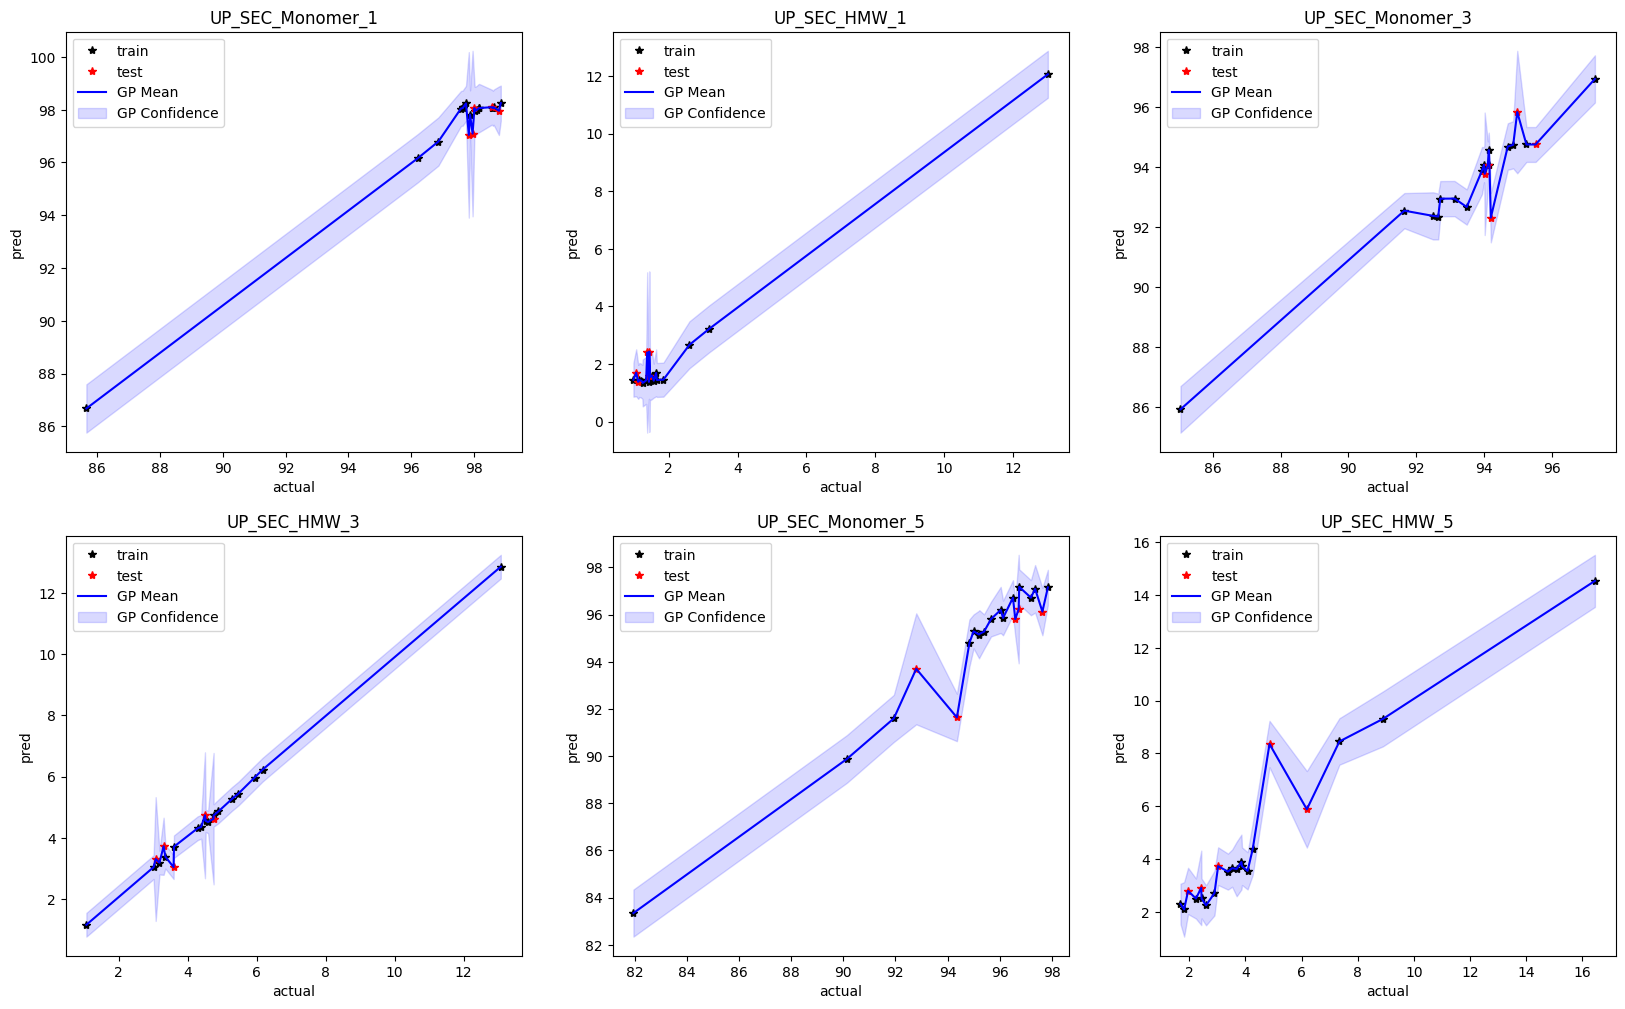

In [577]:
X = df_X_train.to_numpy()
arr_train_metrics = np.zeros((8,6))
arr_test_metrics = np.zeros((8,6))
# Initialize plots
f, y_axes = plt.subplots(2, 3, figsize=(20, 12))
y_axes = y_axes.ravel()

for j,tmp_col_y in enumerate(cols_target_new):   
    Y = df_y_train.to_numpy()[:,j]
    
    model = lvgp_fit(X, Y, ind_qual=[0], n_opt=8, noise=True, dim_z = 1)
    
    X_te = df_X_test.to_numpy()
    Y_te = df_y_test.to_numpy()[:,j]
    test_pred = lvgp_predict(X_te, model, MSE_on=True)
    test_std = test_pred['MSE']
    arr_test_pred = test_pred['Y_hat'].reshape(-1)
    
    test_comp = np.concatenate((Y_te.reshape(-1,1),arr_test_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + test_std.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - test_std.squeeze()
    df_test_comp['mode'] = 'test'
    
    train_pred = lvgp_predict(X, model, MSE_on=True)
    train_std = train_pred['MSE']
    arr_train_pred = train_pred['Y_hat'].reshape(-1)
    train_comp = np.concatenate((Y.reshape(-1,1),arr_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + train_std.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - train_std.squeeze()
    df_train_comp['mode'] = 'train'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    for i in range(Y_te.shape[0]):
         e = ei(arr_test_pred[i], test_std[i], loss_optimum=np.min(Y))
         print(round(Y_te[i], 2), round(arr_test_pred[i], 2), round(test_std[i], 2), round(e, 3))
    
    
    print('RMSE: ', "{:.2f}".format(np.sqrt(mean_squared_error(Y_te, arr_test_pred))/(max(Y_te)-min(Y_te))))
    print('R2 : ', "{:.2f}".format(r2_score(Y_te, arr_test_pred)))
    print('cate latent values: ',model['qualitative_params']['z_vec'])

       # Plot training data as black stars
    y_axes[j].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')

    # Plot training data as red stars
    y_axes[j].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red')
    # Predictive mean as blue line
    y_axes[j].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    # Shade in confidence
    
    y_axes[j].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    y_axes[j].legend(['train','test','GP Mean', 'GP Confidence'])
    y_axes[j].set_title(tmp_col_y)
    y_axes[j].set_xlabel('actual')
    y_axes[j].set_ylabel('pred')

    arr_test_metrics[0,j] = np.round(metrics.mean_absolute_error(Y_te,arr_test_pred),2)
    arr_test_metrics[1,j] = np.round(metrics.median_absolute_error(Y_te,arr_test_pred),2)
    arr_test_metrics[2,j] = np.round(metrics.mean_squared_error(Y_te,arr_test_pred),2)
    arr_test_metrics[3,j] = round(metrics.root_mean_squared_error(Y_te,arr_test_pred),2)
    arr_test_metrics[4,j] = round(metrics.mean_absolute_percentage_error(Y_te,arr_test_pred),2)
    arr_test_metrics[5,j] = round(metrics.max_error(Y_te,arr_test_pred),2)
    arr_test_metrics[6,j] = round(metrics.explained_variance_score(Y_te,arr_test_pred),2)
    arr_test_metrics[7,j] = round(metrics.r2_score(Y_te,arr_test_pred),2)

    arr_train_metrics[0,j] = round(metrics.mean_absolute_error(Y, arr_train_pred),2)
    arr_train_metrics[1,j] = round(metrics.median_absolute_error(Y, arr_train_pred),2)
    arr_train_metrics[2,j] = round(metrics.mean_squared_error(Y, arr_train_pred),2)
    arr_train_metrics[3,j] = round(metrics.root_mean_squared_error(Y, arr_train_pred),2)
    arr_train_metrics[4,j] = round(metrics.mean_absolute_percentage_error(Y, arr_train_pred),2)
    arr_train_metrics[5,j] = round(metrics.max_error(Y, arr_train_pred),2)
    arr_train_metrics[6,j] = round(metrics.explained_variance_score(Y, arr_train_pred),2)
    arr_train_metrics[7,j] = round(metrics.r2_score(Y, arr_train_pred),2)


plt.savefig(figPath+'/true-pred.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## Simple GP

In [392]:
model_option = 0
x_scale_option = 1
y_scale_option = 0
cate_transform_option = 0
remove_train_outlier_option = 1

model_label = ls_model[model_option]
x_scale_label = ls_x_scale[x_scale_option]
y_scale_label = ls_y_scale[y_scale_option]
cate_transform_label = 'cate_transform_'+ls_cate_transform[cate_transform_option]
remove_train_outlier_label = 'remove_train_outlier_'+str(ls_remove_train_outlier[remove_train_outlier_option])

folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,remove_train_outlier_label])

figPath = 'output21-simpleGP/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [393]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)

print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]

True
True


In [394]:
if ls_remove_train_outlier[remove_train_outlier_option]==1:
    keep1_inds = np.abs(stats.zscore(split1_target_df['UP_SEC_HMW_1']))<3
    keep3_inds = np.abs(stats.zscore(split3_target_df['UP_SEC_HMW_3']))<3
    keep5_inds = np.abs(stats.zscore(split5_target_df['UP_SEC_HMW_5']))<3

    if sum(keep1_inds)<len(split1_target_df):
        idx = np.where(keep1_inds==False)[0].item()
        print('UP_SEC_HMW_1'+' has ',str(len(split1_target_df) - sum(keep1_inds)),' outliers at index', str(idx))
        print('y', str(split1_target_df['UP_SEC_HMW_1'][idx]))
    
    if sum(keep3_inds)<len(split3_target_df):
        idx = np.where(keep3_inds==False)[0].item()
        print('UP_SEC_HMW_3'+' has ',str(len(split3_target_df) - sum(keep3_inds)),' outliers at index', str(idx))
        print('y', str(split3_target_df['UP_SEC_HMW_3'][idx]))
    
    if sum(keep5_inds)<len(split5_target_df):
        idx = np.where(keep5_inds==False)[0].item()
        print('UP_SEC_HMW_5'+' has ',str(len(split5_target_df) - sum(keep5_inds)),' outliers at index', str(idx))
        print('y', str(split5_target_df['UP_SEC_HMW_5'][idx]))

    split1_target_df = split1_target_df[(keep1_inds)]
    split3_target_df = split3_target_df[(keep3_inds)]
    split5_target_df = split5_target_df[(keep5_inds)]

    split1_formulation_df = split1_formulation_df[(keep1_inds)]
    split3_formulation_df = split3_formulation_df[(keep3_inds)]
    split5_formulation_df = split5_formulation_df[(keep5_inds)]

    #split1_target_df.reset_index(inplace = True, drop = True)
    #split3_target_df.reset_index(inplace = True, drop = True)
    #split5_target_df.reset_index(inplace = True, drop = True)

    #split1_formulation_df.reset_index(inplace = True, drop = True)

UP_SEC_HMW_1 has  1  outliers at index 16
y 13.02
UP_SEC_HMW_3 has  1  outliers at index 16
y 13.08
UP_SEC_HMW_5 has  1  outliers at index 16
y 16.45


In [395]:
n21_total_df = pd.concat((split1_formulation_df,split1_target_df,split3_target_df,split5_target_df),axis = 1)
#n21_total_df
ohe_n21_total_df = pd.get_dummies(n21_total_df, columns = ['Buffer'])
#ohe_n21_total_df.head()

In [396]:
##Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(ohe_n21_total_df[cols_feature_new], ohe_n21_total_df[cols_target_new], test_size=0.2, random_state=0)

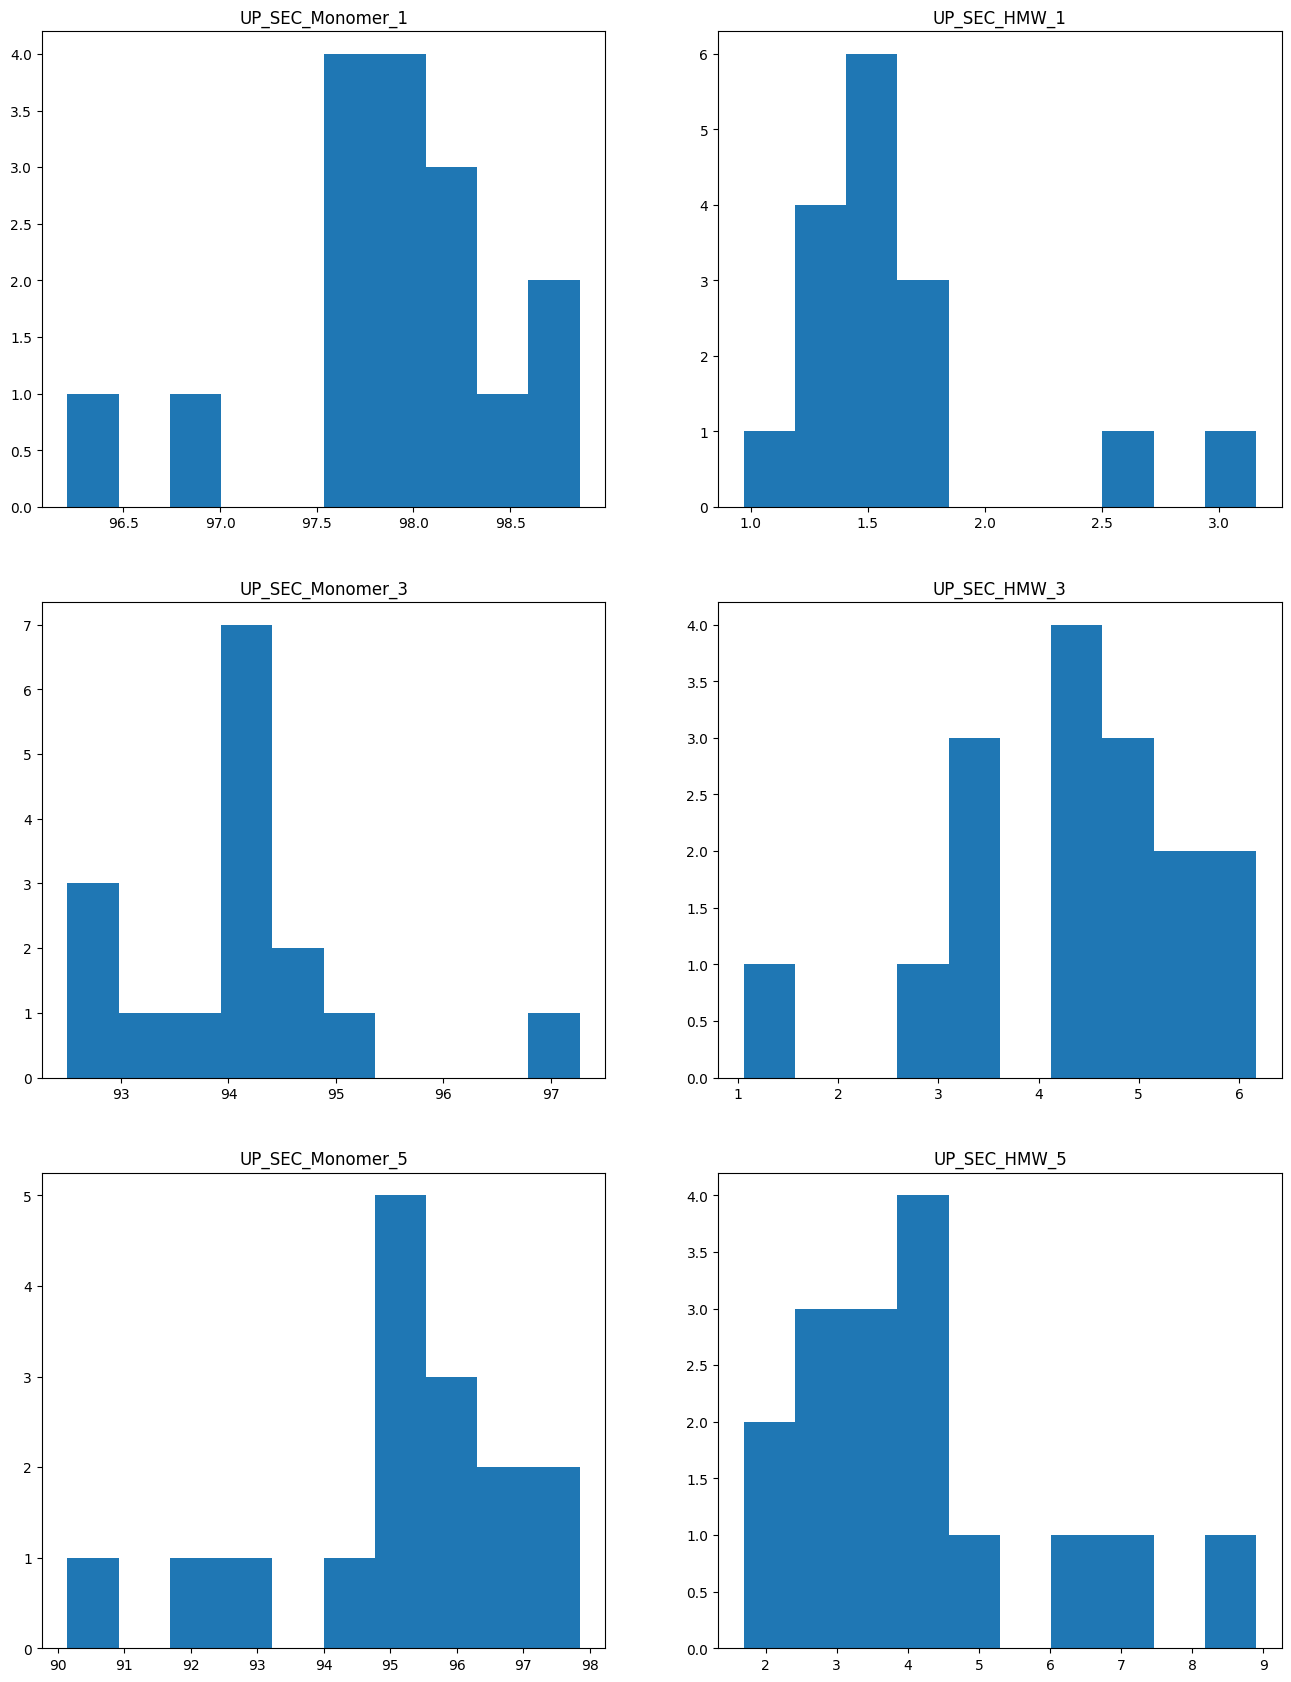

In [397]:
# scale features
x_mm_scaler = MinMaxScaler()
X_train=x_mm_scaler.fit_transform(df_X_train)
X_test=x_mm_scaler.transform(df_X_test)

y_train_all=df_y_train.values


f, y_axes = plt.subplots(3, 2, figsize=(16, 21))
y_axes = y_axes.ravel()

y_train_scale = y_train_all.copy()
#y_train_scale = np.zeros((y_train_all.shape[0],3))
#y_train_scale = y_train_all[:,[0,2,4]]

ls_y_scaler = []
for i,tmp_col_y in enumerate(cols_target_new):
    #y_train = y_train_all[:,(i-1)*2]
    y_train = y_train_all[:,i]
    
    """
    if y_scale_label=='y-robust':
        y_scaler = RobustScaler()
        y_train_scale[:,i] = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

    if y_scale_label=='y-stand':
        y_scaler = StandardScaler()
        y_train_scale[:,i] = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

    if y_scale_label=='y-minmax':
        y_scaler = MinMaxScaler()
        y_train_scale[:,i] = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
    
    ls_y_scaler.append(y_scaler)
    """
    y_axes[i].hist(y_train_scale[:,i])
    y_axes[i].set_title(tmp_col_y)

47.6**2 * RBF(length_scale=2.39)
1.83**2 * RBF(length_scale=0.578)
45.4**2 * RBF(length_scale=2.56)
5.09**2 * RBF(length_scale=1.09)
57.4**2 * RBF(length_scale=3.02)
5.29**2 * RBF(length_scale=1.28)
         UP_SEC_Monomer_1  UP_SEC_HMW_1  UP_SEC_Monomer_3  UP_SEC_HMW_3  \
MAE                 24.75          0.48             24.73          1.37   
MAE2                 0.85          0.33              2.62          0.95   
MSE               2363.61          0.37           2176.71          3.87   
RMSE                48.62          0.61             46.66          1.97   
MAPE                 0.25          0.43              0.26          0.39   
MAXE                97.22          1.11             93.23          3.59   
EVS             -18047.02         -9.01           -771.61         -8.44   
R2              -23771.75        -24.41           -989.71        -17.37   
AVG_STD             12.04          0.79             11.45          1.47   
MIN_STD              0.10          0.26            

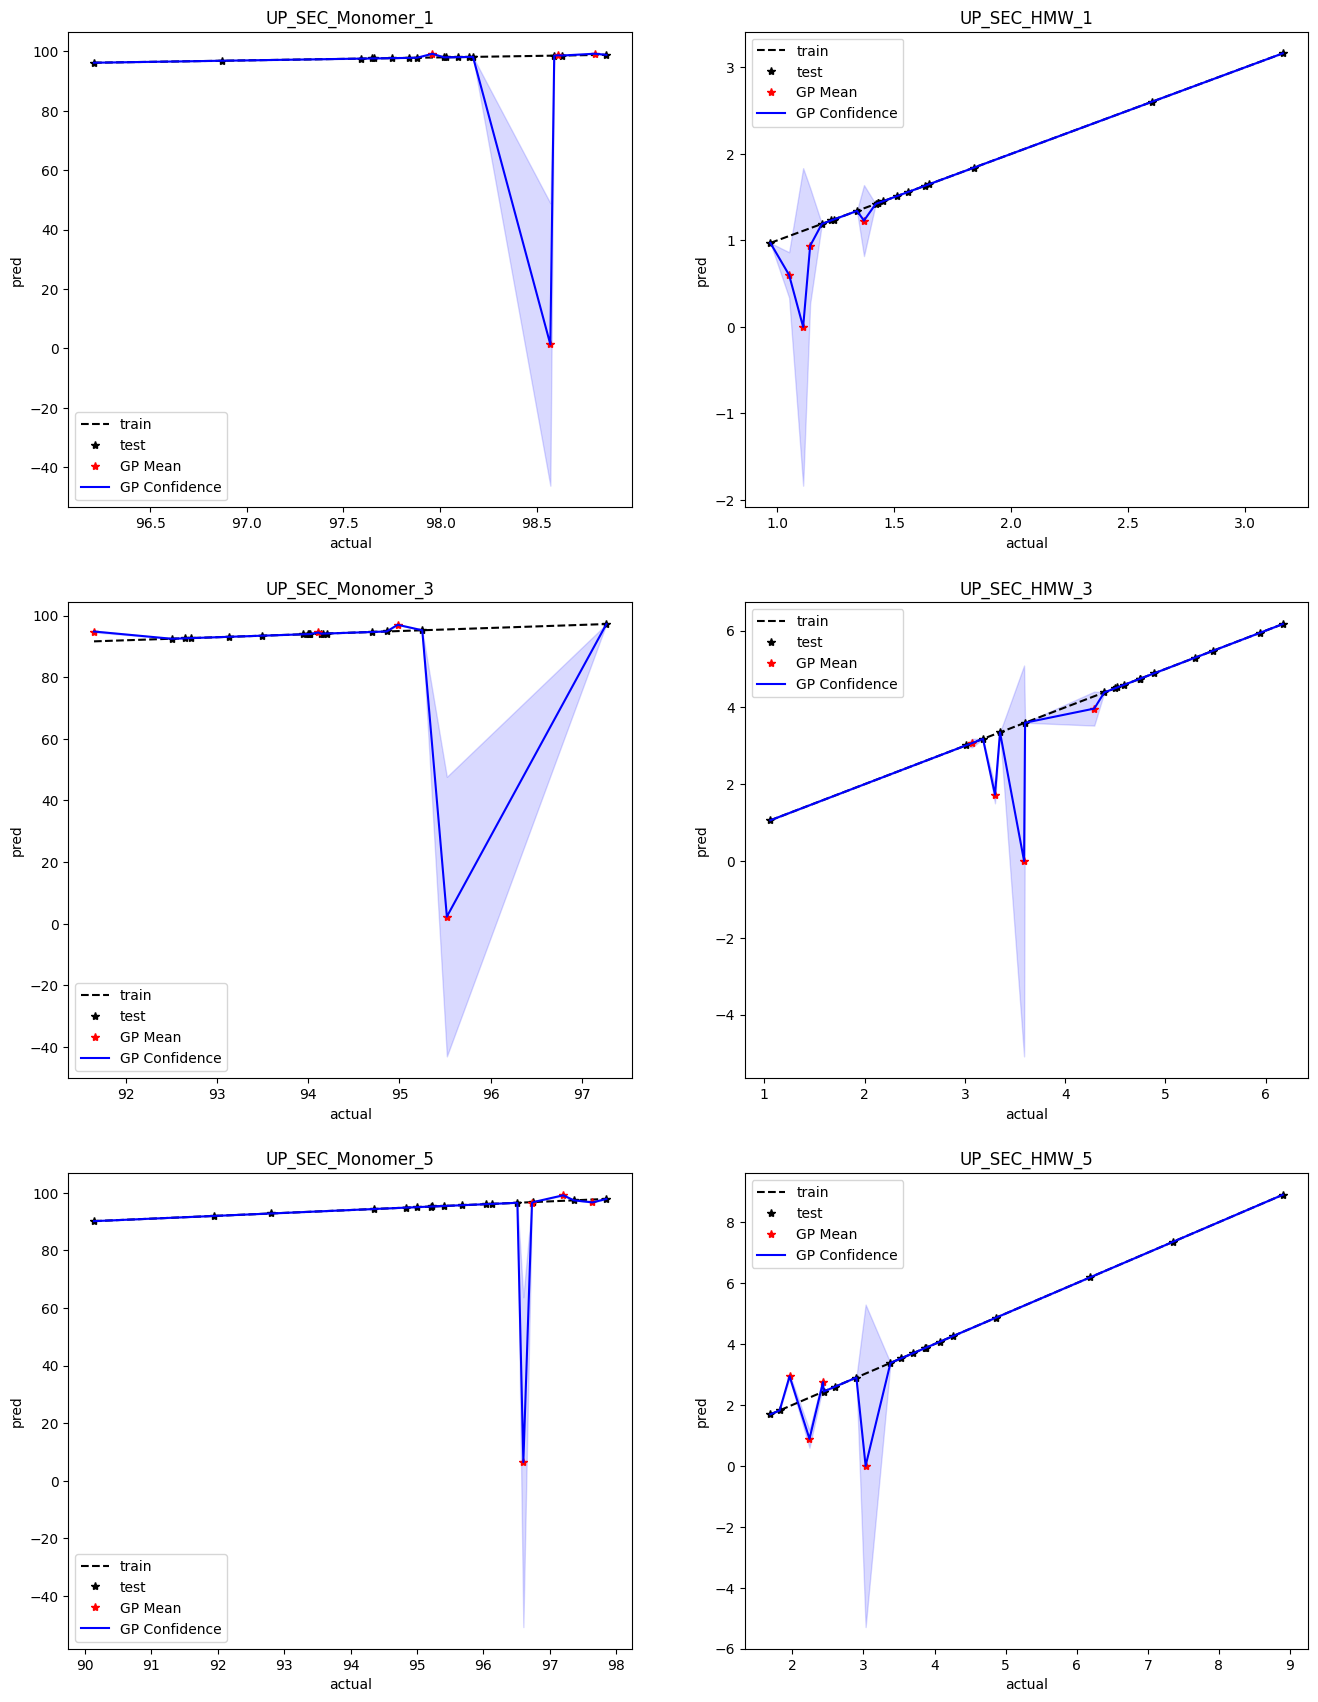

In [398]:
remove_pred_outlier = False
save_fig = True
save_metrics = True

num_outputs = 2
num_tasks = 3

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
ls_df_test_comp = []
arr_train_metrics = np.zeros((13,6))
arr_test_metrics = np.zeros((11,6))
# Initialize plots

f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))

y_axes = y_axes.ravel()
# Make predictions
for i,tmp_col_y in enumerate(cols_target_new):
    if y_scale_option ==2:
        my_gpr = MyGPR2(kernel=kernel, n_restarts_optimizer=9,normalize_y = True)
    else:
        my_gpr = MyGPR2(kernel=kernel, n_restarts_optimizer=9,normalize_y = False)
    #my_gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,normalize_y = True)
    """
    y_train = y_train_all[:,i]
    if y_scale_label=='y-robust':
        y_scaler = RobustScaler()
        y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

    if y_scale_label=='y-stand':
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

    if y_scale_label=='y-minmax':
        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
    """
    q1 = np.percentile(y_train, 25)
    q3 = np.percentile(y_train, 75)
    iqr = q3 - q1
    lb = q1 - 4*iqr
    ub = q3 + 4*iqr

    X_train_new = X_train
    y_train = y_train_scale[:,i]
    my_gpr.fit(X_train_new,y_train)
    print(my_gpr.kernel_)
    
    mean_train_pred, std_train_pred = my_gpr.predict(X_train_new, return_std=True)
    
    mean_test_pred, std_test_pred = my_gpr.predict(X_test, return_std=True)
    """
    #print('----before inverse transform----')
    #print(std_train_pred)

    
    y_scaler = ls_y_scaler[i]
    if y_scale_option!=0:
        mean_train_pred = y_scaler.inverse_transform(mean_train_pred.reshape(-1,1))
        std_train_pred = y_scaler.inverse_transform(std_train_pred.reshape(-1,1))
        mean_test_pred = y_scaler.inverse_transform(mean_test_pred.reshape(-1,1))
        std_test_pred = y_scaler.inverse_transform(std_test_pred.reshape(-1,1))
        y_train= y_scaler.inverse_transform(y_train.reshape(-1,1))
    
    #print('----after inverse transform----')
    #print(std_train_pred)
    """
    y_true = df_y_test[tmp_col_y].values
    y_pred = mean_test_pred

    
    test_comp = np.concatenate((y_true.reshape(1,-1),y_pred.reshape(1,-1)))
    df_test_comp = pd.DataFrame(test_comp.transpose(),columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    ls_df_test_comp.append(df_test_comp)
    
    train_comp = np.concatenate((y_train.reshape(1,-1),mean_train_pred.reshape(1,-1)))
    df_train_comp = pd.DataFrame(train_comp.transpose(),columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'

    if remove_pred_outlier==1:

        a = df_train_comp['pred']>ub
        b = df_train_comp['pred']<lb
        is_train_outlier = np.logical_or(a,b)
        not_train_outlier = np.logical_not(np.logical_or(a,b))
    
        if sum(is_train_outlier)>0:
            print(tmp_col_y+' has ',str(sum(is_train_outlier)),' train outliers at index', str(is_train_outlier.nonzero()[0]))
            print('x values', str(X_train[is_train_outlier.squeeze()]))
            print('y train', str(y_train[is_train_outlier]))
        
        a = df_test_comp['pred']>ub
        b = df_test_comp['pred']<lb
        is_test_outlier = np.logical_or(a.values,b.values)
        not_test_outlier = np.logical_not(np.logical_or(a.values,b.values))
        df_test_comp = df_test_comp[not_test_outlier]
        if sum(is_test_outlier)>0:
            print(tmp_col_y+' has ',str(sum(is_test_outlier)),' test outliers at index', str(is_test_outlier.nonzero()[0]))
            print('x values', str(X_test[is_test_outlier]))
            print('y true', str(y_true[is_test_outlier]))
            print('y pred', str(y_pred[is_test_outlier]))
        

    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)
    
    

    #plot a parity line
    y_axes[i].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    # Plot training data as black stars
    y_axes[i].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')

    # Plot training data as red stars
    y_axes[i].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red')
    # Predictive mean as blue line
    y_axes[i].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    #y_axes[i].plot(t_comp[:, 0].numpy(), t_comp[:, 1].numpy(), c = 'b')
    # Shade in confidence
    #y_axes[i].fill_between(t_comp[:, 0], t_comp[:, 2], t_comp[:, 3], alpha=0.5)
    y_axes[i].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    y_axes[i].legend(['train','test','GP Mean', 'GP Confidence'])
    y_axes[i].set_title(tmp_col_y)
    y_axes[i].set_xlabel('actual')
    y_axes[i].set_ylabel('pred')

    arr_test_metrics[0,i] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,i] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,i] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,i] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,i] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,i] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,i] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,i] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,i] = round(np.mean(std_test_pred),2)
    arr_test_metrics[9,i] = round(np.min(std_test_pred),2)
    arr_test_metrics[10,i] = round(np.max(std_test_pred),2)
    

    arr_train_metrics[0,i] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,i] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,i] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,i] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,i] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,i] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,i] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,i] = round(metrics.r2_score(y_train, mean_train_pred),2)
    arr_train_metrics[8,i] = round(np.mean(std_train_pred),2)
    arr_train_metrics[9,i] = round(np.min(std_train_pred),2)
    arr_train_metrics[10,i] = round(np.max(std_train_pred),2)
    arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if save_fig:
    if remove_pred_outlier:
        plt.savefig(figPath+'/true-pred-remove-out.jpg')
    else:
        plt.savefig(figPath+'/true-pred.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2',
                                        'AVG_STD','MIN_STD','MAX_STD','rbf_variance_scale','rbf_length'])
print(df_train_metrics)

if save_metrics:
    df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
    df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## Multi-task GP

In [443]:
model_option = 1
x_scale_option = 1
y_scale_option = 1
cate_transform_option = 0

model_label = ls_model[model_option]
x_scale_label = ls_x_scale[x_scale_option]
y_scale_label = ls_y_scale[y_scale_option]
cate_transform_label = ls_cate_transform[cate_transform_option]

folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label])
print(folder_name)

multi-task-same-input-x-minmax-y-minmax-ohe


In [444]:

figPath = 'rank0/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder rank0/multi-task-same-input-x-minmax-y-minmax-ohe


In [594]:
#!/usr/bin/env python3

from typing import Optional

from linear_operator import to_linear_operator
from linear_operator.operators import KroneckerProductLinearOperator

from gpytorch.priors import Prior
from gpytorch.kernels.index_kernel import IndexKernel
from gpytorch.kernels.kernel import Kernel


class MultitaskKernel2(Kernel):
    r"""
    Kernel supporting Kronecker style multitask Gaussian processes (where every data point is evaluated at every
    task) using :class:`gpytorch.kernels.IndexKernel` as a basic multitask kernel.

    Given a base covariance module to be used for the data, :math:`K_{XX}`, this kernel computes a task kernel of
    specified size :math:`K_{TT}` and returns :math:`K = K_{TT} \otimes K_{XX}`. as an
    :obj:`~linear_operator.operators.KroneckerProductLinearOperator`.

    :param ~gpytorch.kernels.Kernel data_covar_module: Kernel to use as the data kernel.
    :param int num_tasks: Number of tasks
    :param int rank: (default 1) Rank of index kernel to use for task covariance matrix.
    :param ~gpytorch.priors.Prior task_covar_prior: (default None) Prior to use for task kernel.
        See :class:`gpytorch.kernels.IndexKernel` for details.
    :param dict kwargs: Additional arguments to pass to the kernel.
    """

    def __init__(
        self,
        data_covar_module: Kernel,
        num_tasks: int,
        rank: Optional[int] = 1,
        task_covar_prior: Optional[Prior] = None,
        **kwargs,
    ):
        """"""
        super(MultitaskKernel2, self).__init__(**kwargs)
        self.task_covar_module = IndexKernel(
            num_tasks=num_tasks, batch_shape=self.batch_shape, 
            rank=rank, prior=task_covar_prior
        )
        self.task_covar_module._parameters['raw_var'] = torch.zeros(num_tasks)
        self.data_covar_module = data_covar_module
        self.num_tasks = num_tasks

    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            raise RuntimeError("MultitaskKernel does not accept the last_dim_is_batch argument.")
        covar_i = self.task_covar_module.covar_matrix
        #covar_i = torch.eye(num_tasks)
        if len(x1.shape[:-2]):
            covar_i = covar_i.repeat(*x1.shape[:-2], 1, 1)
        self.covar_i = covar_i
        covar_x = to_linear_operator(self.data_covar_module.forward(x1, x2, **params))
        self.covar_x = covar_x
        res = KroneckerProductLinearOperator(covar_x, covar_i)
        res = res.diagonal(dim1=-1, dim2=-2) if diag else res
        self.res = res
        return res

    def num_outputs_per_input(self, x1, x2):
        """
        Given `n` data points `x1` and `m` datapoints `x2`, this multitask
        kernel returns an `(n*num_tasks) x (m*num_tasks)` covariance matrix.
        """
        return self.num_tasks

In [595]:
mt_kernel = MultitaskKernel2(data_covar_module = gpytorch.kernels.RBFKernel(),num_tasks=6,rank = 0)
#mt_kernel.task_covar_module._parameters['raw_var']
mt_kernel.task_covar_module.covar_matrix.evaluate()

tensor([[0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6931, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6931, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6931, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6931]],
       grad_fn=<AddBackward0>)

In [596]:
tmp = mt_kernel(t_train_x[0,:],t_train_x[1,:]).evaluate()
tmp.shape

torch.Size([48, 48])

In [597]:
mt_kernel.covar_i.evaluate()

tensor([[0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6931, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6931, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6931, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6931]],
       grad_fn=<AddBackward0>)

In [598]:
mt_kernel.covar_x.evaluate()

tensor([[0.3532, 0.3532, 1.0000, 1.0000, 0.3532, 0.3532, 0.3532, 0.8908],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297],
        [0.3532, 0.3532, 1.0000, 1.0000, 0.3532, 0.3532, 0.3532, 0.8908],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297],
        [1.0000, 1.0000, 0.3532, 0.3532, 1.0000, 1.0000, 1.0000, 0.6297]],
       grad_fn=<RBFCovarianceBackward>)

In [582]:
class MultitaskGPModel2(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel2, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=6
        )
        self.covar_module = MultitaskKernel2(
            gpytorch.kernels.RBFKernel(), num_tasks=6, rank=0
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [583]:
##Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(ohe_n21_total_df[cols_feature_new], ohe_n21_total_df[cols_target_new], test_size=0.2, random_state=0)

In [584]:
# scale features
x_mm_scaler = MinMaxScaler()
X_train=x_mm_scaler.fit_transform(df_X_train)
X_test=x_mm_scaler.transform(df_X_test)

if y_scale_option==1:
    y_scaler = RobustScaler()
    y_train = y_scaler.fit_transform(df_y_train)
    #y_test = y_scaler.transform(df_y_test)

if y_scale_label=='y-minmax':
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(df_y_train)
    #y_test = y_scaler.transform(df_y_test)

In [585]:
remove_outlier = False
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 500

t_train_x = torch.tensor(X_train, dtype=torch.float)
t_train_y  = torch.tensor(df_y_train.to_numpy(), dtype=torch.float)
if y_scale_label!='no-y-scale':
    t_train_y  = torch.tensor(y_train, dtype=torch.float)
    #t_train_y = t_train_y

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=6)
#model = MultitaskGPModel(t_train_x, t_train_y, likelihood)
model = MultitaskGPModel2(t_train_x, t_train_y, likelihood)

In [586]:
#https://stackoverflow.com/questions/76251549/setting-the-task-covariance-matrix-to-the-correlation-matrix-in-gpytorch
model.covar_module.task_covar_module._parameters['raw_var'] = torch.zeros_like(model.covar_module.task_covar_module._parameters['raw_var'])

In [587]:
model.covar_module.task_covar_module.covar_matrix.evaluate()

tensor([[0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6931, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6931, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6931, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6931]],
       grad_fn=<AddBackward0>)

In [591]:
model.covar_module.res

In [588]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: 1.300
Iter 2/500 - Loss: 1.258
Iter 3/500 - Loss: 1.219
Iter 4/500 - Loss: 1.182
Iter 5/500 - Loss: 1.147
Iter 6/500 - Loss: 1.112
Iter 7/500 - Loss: 1.077
Iter 8/500 - Loss: 1.042
Iter 9/500 - Loss: 1.007
Iter 10/500 - Loss: 0.970
Iter 11/500 - Loss: 0.934
Iter 12/500 - Loss: 0.897
Iter 13/500 - Loss: 0.859
Iter 14/500 - Loss: 0.822
Iter 15/500 - Loss: 0.784
Iter 16/500 - Loss: 0.746
Iter 17/500 - Loss: 0.709
Iter 18/500 - Loss: 0.671
Iter 19/500 - Loss: 0.634
Iter 20/500 - Loss: 0.597
Iter 21/500 - Loss: 0.561
Iter 22/500 - Loss: 0.526
Iter 23/500 - Loss: 0.491
Iter 24/500 - Loss: 0.457
Iter 25/500 - Loss: 0.425
Iter 26/500 - Loss: 0.393
Iter 27/500 - Loss: 0.363
Iter 28/500 - Loss: 0.334
Iter 29/500 - Loss: 0.307
Iter 30/500 - Loss: 0.282
Iter 31/500 - Loss: 0.258
Iter 32/500 - Loss: 0.236
Iter 33/500 - Loss: 0.216
Iter 34/500 - Loss: 0.198
Iter 35/500 - Loss: 0.182
Iter 36/500 - Loss: 0.168
Iter 37/500 - Loss: 0.156
Iter 38/500 - Loss: 0.146
Iter 39/500 - Loss: 0

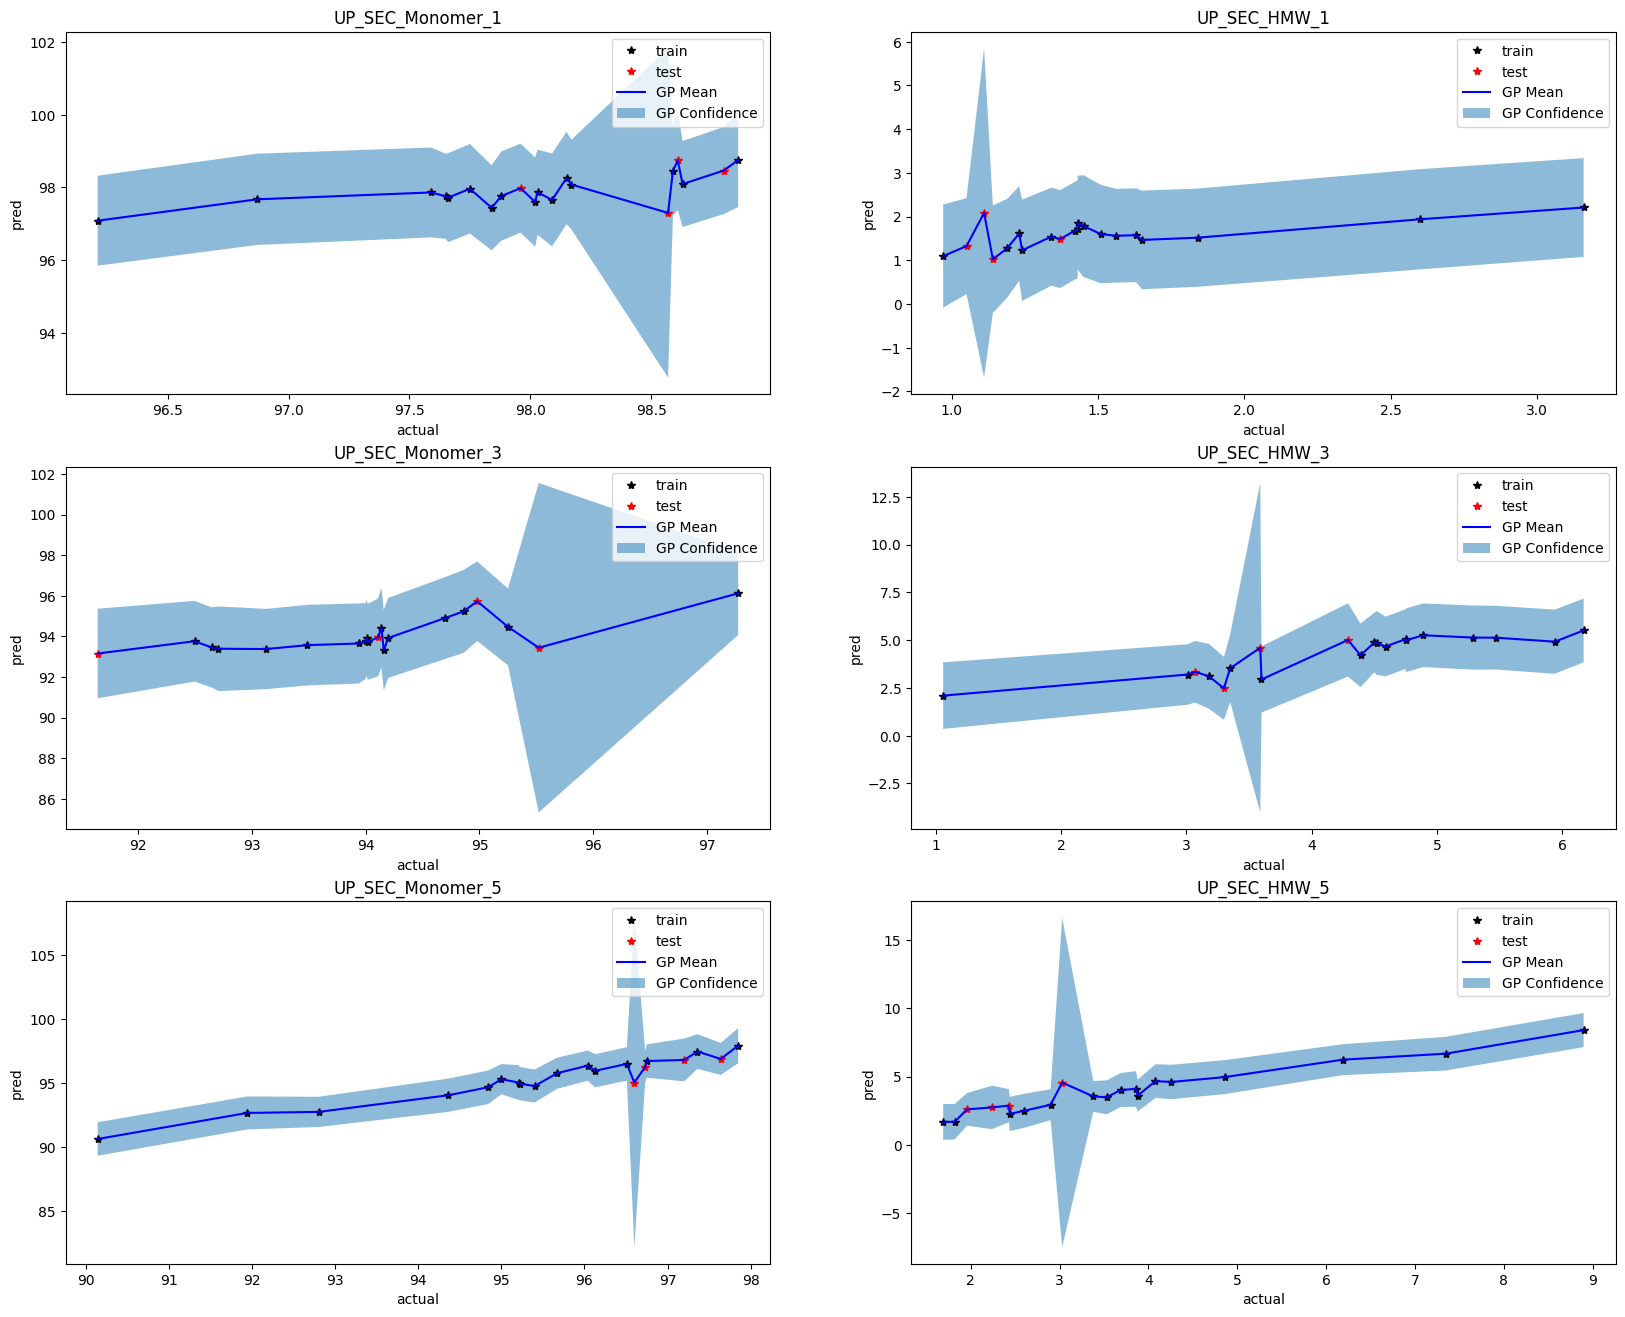

In [544]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

f, y_axes = plt.subplots(3, 2, figsize=(20, 16))

y_axes = y_axes.ravel()
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #predict training
    train_predictions = likelihood(model(t_train_x))
    train_mean = train_predictions.mean
    train_lower, train_upper = train_predictions.confidence_region()
    if y_scale_label!='no-y-scale':
        train_mean = torch.tensor(y_scaler.inverse_transform(train_mean), dtype=torch.float)
        train_lower = torch.tensor(y_scaler.inverse_transform(train_lower), dtype=torch.float)
        train_upper = torch.tensor(y_scaler.inverse_transform(train_upper), dtype=torch.float)
        t_train_y= torch.tensor(y_scaler.inverse_transform(t_train_y), dtype=torch.float)

    #predict testing
    t_test_x = torch.tensor(X_test, dtype=torch.float)
    t_test_y  = torch.tensor(df_y_test.to_numpy(), dtype=torch.float)
    test_predictions = likelihood(model(t_test_x))
    test_mean = test_predictions.mean
    test_lower, test_upper = test_predictions.confidence_region()
    
    if y_scale_label!='no-y-scale':
        test_mean = torch.tensor(y_scaler.inverse_transform(test_mean), dtype=torch.float)
        test_lower = torch.tensor(y_scaler.inverse_transform(test_lower), dtype=torch.float)
        test_upper = torch.tensor(y_scaler.inverse_transform(test_upper), dtype=torch.float)
    
    

for i,col_name in enumerate(cols_target_new):
    t_train_comp = torch.cat((t_train_y.detach()[:, i].reshape(-1,1),
                        train_mean[:, i].reshape(-1,1),
                        train_lower[:, i].reshape(-1,1),
                        train_upper[:, i].reshape(-1,1)),1)
    
    t_test_comp = torch.cat((t_test_y.detach()[:, i].reshape(-1,1),
                        test_mean[:, i].reshape(-1,1),
                        test_lower[:, i].reshape(-1,1),
                        test_upper[:, i].reshape(-1,1)),1)
    
    q1 = np.percentile(t_train_comp[:,0].detach().numpy(), 25)
    q3 = np.percentile(t_train_comp[:,0].detach().numpy(), 75)
    iqr = q3 - q1
    lb = q1 - 4*iqr
    ub = q3 + 4*iqr
    a = t_test_comp[:,0]>ub
    b = t_test_comp[:,0]<lb
    is_test_outlier = torch.logical_or(a,b)
    not_test_outlier = torch.logical_not(torch.logical_or(a,b))
    if sum(is_test_outlier).item()>0:
        print(col_name+' has ',str(sum(is_test_outlier).item()),' outliers at index', str(is_test_outlier.nonzero().squeeze()))
        print('x values', str(t_test_x[is_test_outlier].detach()))
        print('y true', str(t_test_y[is_test_outlier,i]))
        print('y pred', str(test_mean[is_test_outlier,i]))
    
    if remove_outlier:
        t_test_comp = t_test_comp[not_test_outlier]

    t_comp = torch.cat((t_train_comp,t_test_comp),0)

    ind = t_comp[:,0].argsort(dim = 0)
    t_comp = t_comp[ind]
    # Plot training data as black stars
    y_axes[i].plot(t_train_comp[:,0], t_train_comp[:,1], 'k*',c = 'black')

    # Plot training data as red stars
    y_axes[i].plot(t_test_comp[:,0], t_test_comp[:,1], 'k*',c = 'red')
    # Predictive mean as blue line
    y_axes[i].plot(t_comp[:, 0].numpy(), t_comp[:, 1].numpy(), c = 'b')
     # Shade in confidence
    y_axes[i].fill_between(t_comp[:, 0], t_comp[:, 2], t_comp[:, 3], alpha=0.5)
    y_axes[i].legend(['train','test','GP Mean', 'GP Confidence'])
    y_axes[i].set_title(col_name)
    y_axes[i].set_xlabel('actual')
    y_axes[i].set_ylabel('pred')
    
    # Plot training data as black stars
    #y1_ax.plot(t_train_y.detach().numpy(), t_train_y[:, 0].detach().numpy(), 'k*')
    # Predictive mean as blue line
    #y1_ax.plot(t_train_y[:, 0].detach().numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence
    #y1_ax.fill_between(t_train_y[:, 0].detach().numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    #y1_ax.set_ylim([-3, 3])
    #y1_ax.legend(['Mean', 'Confidence'])
    #y1_ax.set_title('Observed Values (Likelihood)')

if remove_outlier:
    plt.savefig(figPath+'/true-pred-remove-out.jpg')
else:
    plt.savefig(figPath+'/true-pred.jpg')

In [546]:
model.covar_module.covar_i.evaluate().shape

torch.Size([6, 6])

UP_SEC_Monomer_1
Mean Absolute Error (MAE): 1.09
Median Absolute Error: 0.87
Mean Squared Error (MSE): 1.32
Root Mean Squared Error (RMSE): 1.15
Mean Absolute Percentage Error (MAPE): 0.01
Max Error: 1.65
Explained Variance Score: 0.00
R^2: -8.32
UP_SEC_HMW_1
Mean Absolute Error (MAE): 1.03
Median Absolute Error: 0.94
Mean Squared Error (MSE): 1.09
Root Mean Squared Error (RMSE): 1.04
Mean Absolute Percentage Error (MAPE): 0.84
Max Error: 1.26
Explained Variance Score: 0.01
R^2: -39.32
UP_SEC_Monomer_3
Mean Absolute Error (MAE): 1.22
Median Absolute Error: 0.85
Mean Squared Error (MSE): 1.83
Root Mean Squared Error (RMSE): 1.35
Mean Absolute Percentage Error (MAPE): 0.01
Max Error: 2.18
Explained Variance Score: 0.00
R^2: -4.32
UP_SEC_HMW_3
Mean Absolute Error (MAE): 1.01
Median Absolute Error: 1.26
Mean Squared Error (MSE): 1.45
Root Mean Squared Error (RMSE): 1.21
Mean Absolute Percentage Error (MAPE): 0.30
Max Error: 1.78
Explained Variance Score: 0.00
R^2: -2.29
UP_SEC_Monomer_5
Me

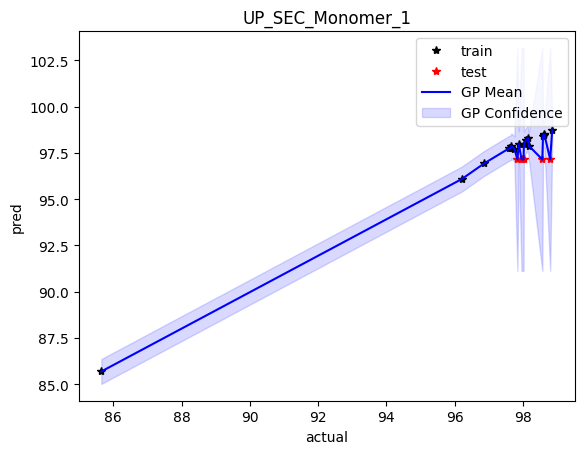

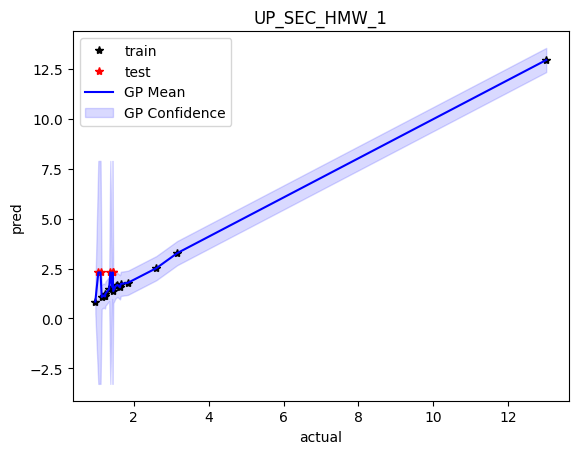

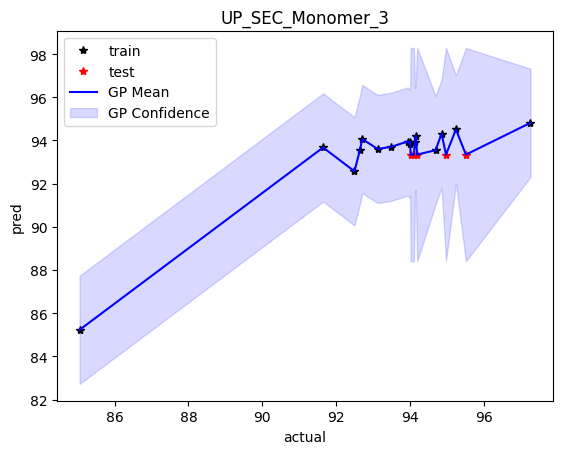

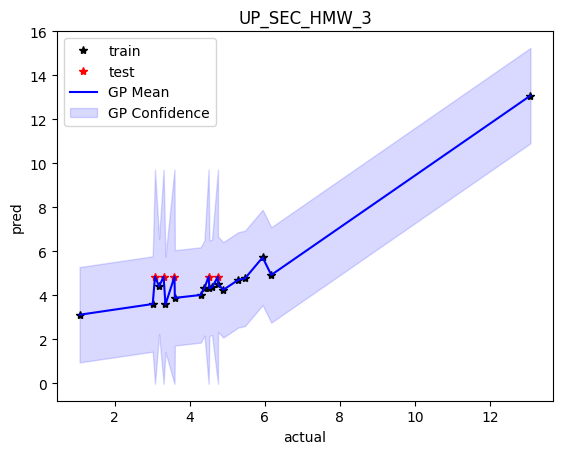

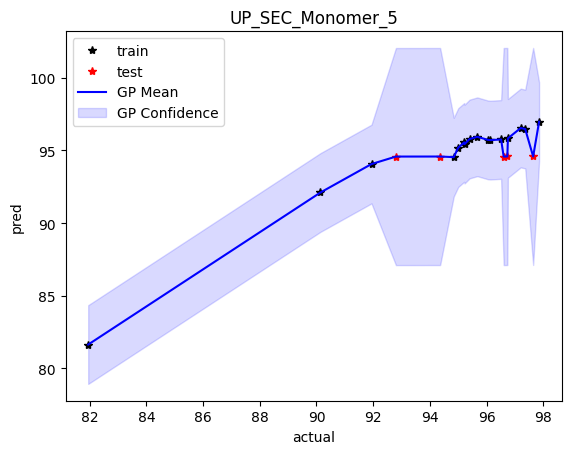

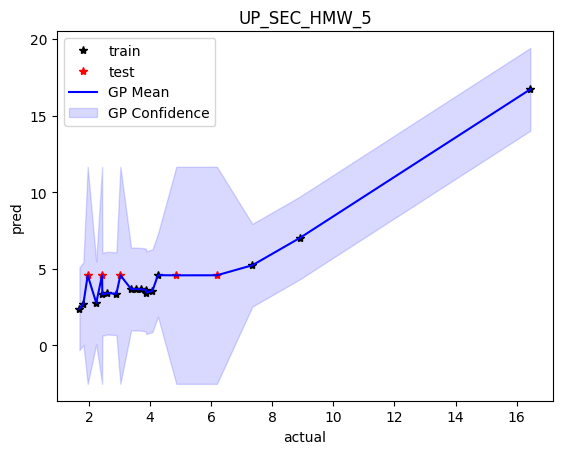

In [602]:
t_std_train = train_mean - train_lower
t_std_test = test_mean - test_lower

arr_train_metrics = np.zeros((8,6))
arr_test_metrics = np.zeros((8,6))

ls_df_test_comp = []
for i,tmp_col_y in enumerate(cols_target_new):
    print(tmp_col_y)

    y_train = t_train_y[:, i].detach().numpy()
    y_true = t_test_y[:, i].detach().numpy()
    
    mean_pred, std_pred = test_mean[:, i].detach().numpy(), t_std_test[:, i].detach().numpy()
    mean_train, std_train = train_mean[:, i].detach().numpy(), t_std_train[:, i].detach().numpy()
    y_pred = mean_pred

    new_y_pred = y_pred
    new_y_true = y_true
    new_std_pred = std_pred

    new_mean_train = mean_train
    new_y_train = y_train
    new_std_train = std_train

    #new_y_pred = np.delete(y_pred, 2)
    #new_y_true = np.delete(y_true, 2)
    #new_std_pred = np.delete(std_pred,2)

    #new_mean_train = np.delete(mean_train, 8)
    #new_y_train = np.delete(y_train, 8)
    #new_std_train = np.delete(std_train,8)

    #if tmp_col_y!='UP_SEC_HMW':
    #print(np.where(abs(y_pred-y_true)>7))
    #print(np.where(abs(mean_train-y_train)>6))
    
    
    #plt.figure(figsize=(12,6))
    #sns.scatterplot(x=new_y_true.reshape(-1), y=new_y_pred.reshape(-1), color='blue', label = 'GP prediction')
    #sns.scatterplot(x=new_y_true.reshape(-1), y=new_y_true.reshape(-1), color='red', label = 'actual data')
    #sns.scatterplot(x=new_y_true.reshape(-1), y=(new_y_pred+1*new_std_pred).reshape(-1), color='yellow', label = 'pred+1*std')
    #sns.scatterplot(x=new_y_true.reshape(-1), y=(new_y_pred-1*new_std_pred).reshape(-1), color='black', label = 'pred-1*std')
    

    test_comp = np.concatenate((new_y_true.reshape(1,-1),new_y_pred.reshape(1,-1)))
    df_test_comp = pd.DataFrame(test_comp.transpose(),columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + new_std_pred
    df_test_comp['lower'] = df_test_comp['pred'] - new_std_pred
    df_test_comp['mode'] = 'test'
    ls_df_test_comp.append(df_test_comp)
    #y_train = df_y_train[tmp_col_y].values
    train_comp = np.concatenate((new_y_train.reshape(1,-1),new_mean_train.reshape(1,-1)))
    df_train_comp = pd.DataFrame(train_comp.transpose(),columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + new_std_train
    df_train_comp['lower'] = df_train_comp['pred'] - new_std_train
    df_train_comp['mode'] = 'train'

    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)
    fig,ax = plt.subplots()
    #ax = sns.lineplot(data=df_comp_sorted, x='true', y='pred')
    ax.plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'black')
    ax.plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red')
    ax.plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    ax.fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    ax.legend(['train','test','GP Mean', 'GP Confidence'])
    ax.set_title(tmp_col_y)
    ax.set_xlabel('actual')
    ax.set_ylabel('pred')


    #_modes = ['train','test']
    #g = sns.relplot(data=df_comp_sorted, x='true', y='pred', hue='mode', hue_order=_modes, aspect=1.61)
    #axis_max = max(max(df_comp_sorted['true']),max(df_comp_sorted['pred']))
    #axis_min = min(min(df_comp_sorted['true']),min(df_comp_sorted['pred']))
    #g.set(xticks=np.linspace(start=axis_min, stop=axis_max, num=8),
    #   yticks=np.linspace(start=axis_min, stop=axis_max, num=8))
    #g.fig.suptitle(tmp_col_y, fontsize=16)
    #g.fig.subplots_adjust(top=0.9)
    #plt.show()
    
    arr_test_metrics[0,i] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,i] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,i] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,i] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,i] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,i] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,i] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,i] = round(metrics.r2_score(y_true, y_pred),2)

    arr_train_metrics[0,i] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,i] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,i] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,i] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,i] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,i] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,i] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,i] = round(metrics.r2_score(y_train, mean_train),2)

    print('Mean Absolute Error (MAE):', "{:.2f}".format(metrics.mean_absolute_error(y_true, y_pred)))
    print('Median Absolute Error:', "{:.2f}".format(metrics.median_absolute_error(y_true, y_pred)))
    print('Mean Squared Error (MSE):', "{:.2f}".format(metrics.mean_squared_error(y_true, y_pred)))
    print('Root Mean Squared Error (RMSE):', "{:.2f}".format(metrics.root_mean_squared_error(y_true, y_pred)))
    print('Mean Absolute Percentage Error (MAPE):', "{:.2f}".format(metrics.mean_absolute_percentage_error(y_true, y_pred)))
    print('Max Error:', "{:.2f}".format(metrics.max_error(y_true, y_pred)))
    #print('Mean Squared Log Error:', "{:.2f}".format(metrics.mean_squared_log_error(y_true, y_pred)))
    print('Explained Variance Score:', "{:.2f}".format(metrics.explained_variance_score(y_true, y_pred)))
    print('R^2:', "{:.2f}".format(metrics.r2_score(y_true, y_pred)))

"""
with np.printoptions(precision=3, suppress=True):
    print(arr_test_metrics)

with np.printoptions(precision=3, suppress=True):
    print(arr_train_metrics)
"""

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')